In [1]:
#import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)


In [2]:
# Load data
DATA_DIR = 'data/prepared'
train = np.load('/Users/claire/Downloads/train_bal_parts0-6_aug.npz')
val   = np.load('/Users/claire/Downloads/val_parts0-6.npz')
test  = np.load('/Users/claire/Downloads/test_external.npz')

X_train, y_train = train['X'], train['y']
X_val, y_val     = val['X'], val['y']
X_test, y_test   = test['X'], test['y']

print('Train :', X_train.shape, 'Positives:', y_train.sum())
print('Val   :', X_val.shape,   'Positives:', y_val.sum())
print('Test  :', X_test.shape,  'Positives:', y_test.sum())

Train : (17880, 2920, 12) Positives: 4470
Val   : (27873, 2920, 12) Positives: 559
Test  : (23430, 2920, 12) Positives: 1631


In [3]:
# Flatten ECGs
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

ipca = IncrementalPCA(n_components=200, batch_size=1000)
ipca.fit(X_train_flat)

X_train_pca = ipca.transform(X_train_flat)
X_val_pca   = ipca.transform(X_val_flat)
X_test_pca  = ipca.transform(X_test_flat)

print("Shapes after PCA:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)


Shapes after PCA: (17880, 200) (27873, 200) (23430, 200)


In [4]:
# Train baseline RF
rf_full = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_full.fit(X_train_pca, y_train)
print("Random Forest training complete.")


python(8121) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Random Forest training complete.


In [9]:
def rf_report(model, name, X_split, y_split, plot_cm=True):
    """Evaluate Random Forest classifier similar to keras_report."""
    y_prob = model.predict_proba(X_split)[:, 1]
    y_pred = (y_prob >= 0.5)

    acc = accuracy_score(y_split, y_pred)
    auroc = roc_auc_score(y_split, y_prob)
    auprc = average_precision_score(y_split, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(y_split, y_pred, average="binary", zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_split, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{name} metrics")
    print(f"accuracy     {acc:.3f}")
    print(f"AUROC        {auroc:.3f}")
    print(f"AUPRC        {auprc:.3f}")
    print(f"precision    {prec:.3f}")
    print(f"recall       {rec:.3f}")
    print(f"specificity  {specificity:.3f}")
    print(f"F1           {f1:.3f}\n")

    if plot_cm:
        ConfusionMatrixDisplay(confusion_matrix(y_split, y_pred), display_labels=["Neg", "Pos"]).plot(cmap="Blues")
        plt.title(f"{name} Confusion Matrix")
        plt.show()

Train metrics
accuracy     1.000
AUROC        1.000
AUPRC        1.000
precision    1.000
recall       1.000
specificity  1.000
F1           1.000



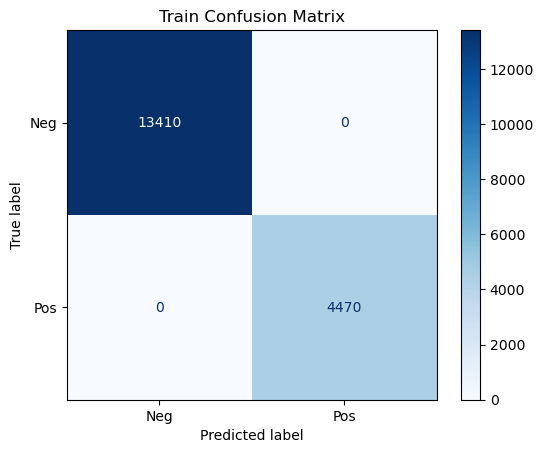

Validation metrics
accuracy     0.972
AUROC        0.756
AUPRC        0.067
precision    0.110
recall       0.055
specificity  0.991
F1           0.074



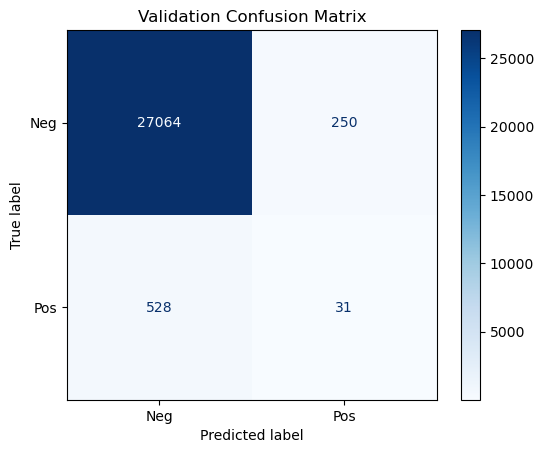

External Test metrics
accuracy     0.924
AUROC        0.402
AUPRC        0.074
precision    0.175
recall       0.025
specificity  0.991
F1           0.044



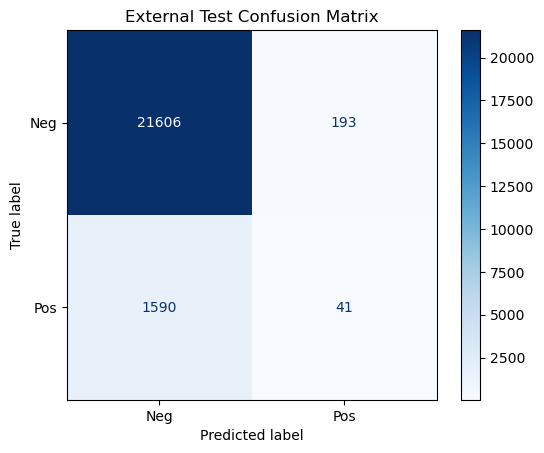

In [10]:
# Evaluate

rf_report(rf_full, "Train", X_train_pca, y_train)
rf_report(rf_full, "Validation", X_val_pca, y_val)
rf_report(rf_full, "External Test", X_test_pca, y_test)

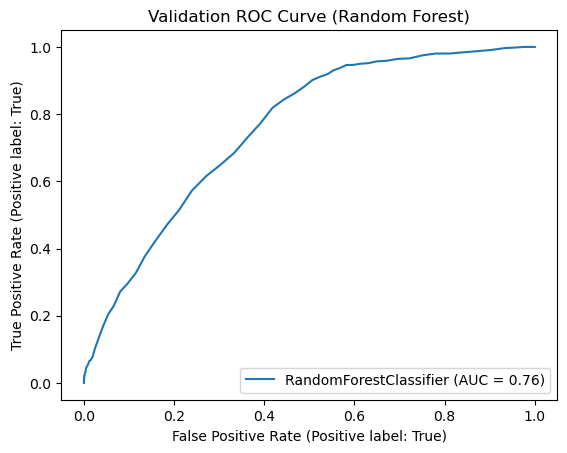

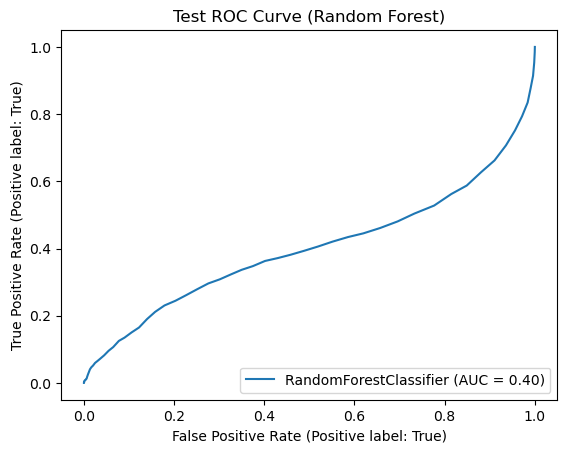

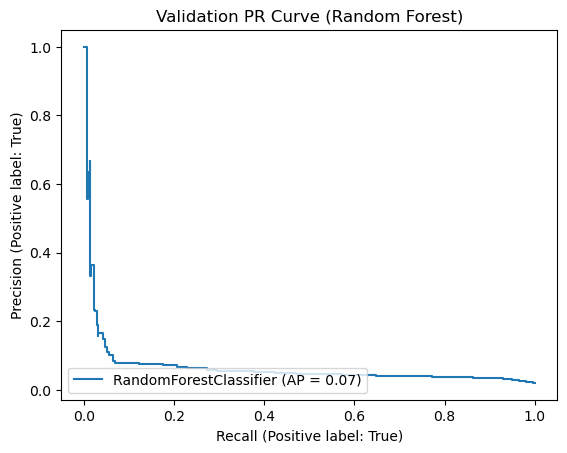

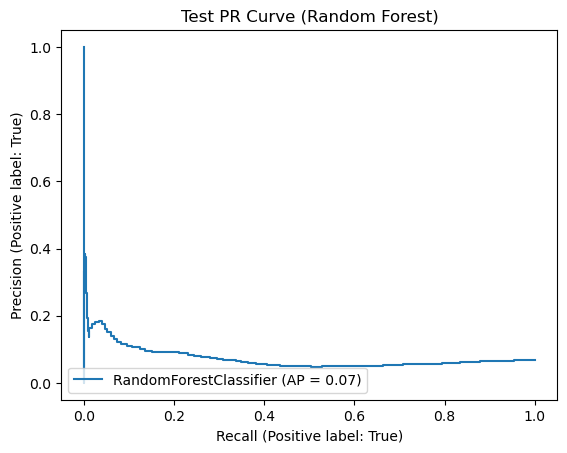

In [11]:
# ROC Curves
RocCurveDisplay.from_estimator(rf_full, X_val_pca, y_val)
plt.title("Validation ROC Curve (Random Forest)")
plt.show()

RocCurveDisplay.from_estimator(rf_full, X_test_pca, y_test)
plt.title("Test ROC Curve (Random Forest)")
plt.show()

# Precision-Recall Curves
PrecisionRecallDisplay.from_estimator(rf_full, X_val_pca, y_val)
plt.title("Validation PR Curve (Random Forest)")
plt.show()

PrecisionRecallDisplay.from_estimator(rf_full, X_test_pca, y_test)
plt.title("Test PR Curve (Random Forest)")
plt.show()

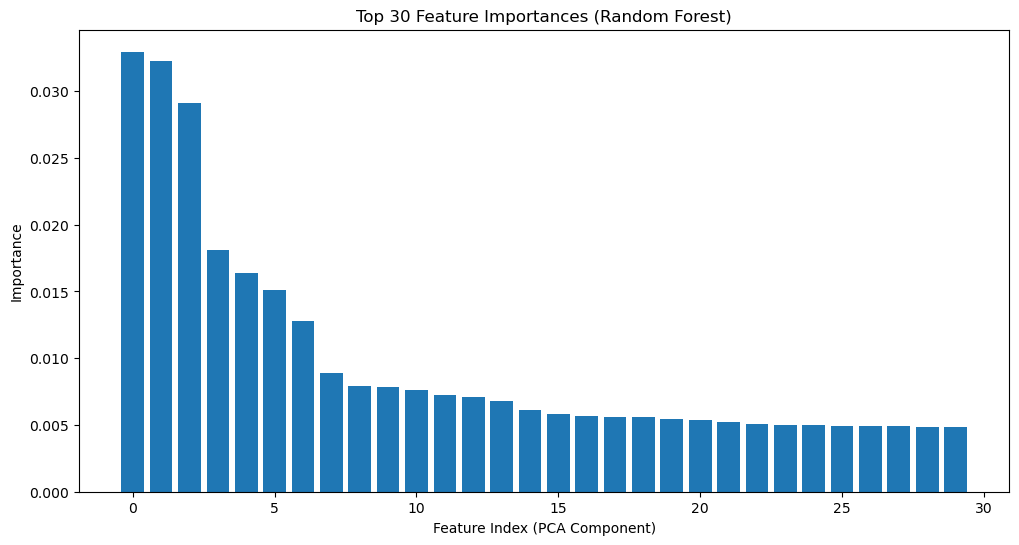

In [12]:
importances = rf_full.feature_importances_
indices = np.argsort(importances)[::-1][:30]

plt.figure(figsize=(12,6))
plt.bar(range(len(indices)), importances[indices])
plt.title('Top 30 Feature Importances (Random Forest)')
plt.xlabel('Feature Index (PCA Component)')
plt.ylabel('Importance')
plt.show()
